In [34]:
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
# Load the ROUGE metric
import evaluate
from evaluate import load

import pandas as pd

In [35]:
!ollama list

NAME                                             ID              SIZE      MODIFIED     
qwen3:0.6b                                       7df6b6e09427    522 MB    2 weeks ago     
llama3.2:latest                                  a80c4f17acd5    2.0 GB    2 weeks ago     
cwchang/llama3-taide-lx-8b-chat-alpha1:latest    31183ddd60a7    5.7 GB    2 weeks ago     
kenneth85/llama-3-taiwan:latest                  c66e73d12b6d    4.7 GB    2 weeks ago     
ycchen/breeze-7b-instruct-v1_0:latest            6207d6d81c31    4.3 GB    2 weeks ago     
qwen2.5:1.5b                                     65ec06548149    986 MB    2 weeks ago     
qwen3:1.7b                                       8f68893c685c    1.4 GB    2 weeks ago     
llama3.1:latest                                  46e0c10c039e    4.9 GB    2 weeks ago     
glm4:latest                                      5b699761eca5    5.5 GB    2 weeks ago     
qwen2.5:latest                                   845dbda0ea48    4.7 GB    2 weeks 

In [36]:
# read files(src)
# 1 document 一行，||||| 分段落
'''f = open("./Data/train.src.txt","r")
train_data = f.readlines()
for i in range(len(content)):
    train_data.append(content[i].split("|||||"))
f.close()'''

f = open("./Data/test.src.txt","r")
test_data = f.readlines()
f.close()

'''f = open("./Data/val.src.txt","r")
val_data = f.readlines()
f.close()'''

print(f"test: {len(test_data)}")#(f"train: {len(train_data)}\ntest: {len(test_data)}\nval: {len(val_data)}")

test: 5622


In [37]:
f = open("./Data/test.txt","r")
test_result = f.readlines()
f.close()

print(test_result[0])
print(len(test_result))

– It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.

5622


In [38]:
import requests

def chat_with_ollama(document, model="llama3:8b"):
    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
    data = {
        "model": model,
        "messages":[{"role": "system", "content": "Summarize the text into a short. Output only the summary itself."},""],
        # "prompt": "Summarize the following text into a short. Output only the summary itself.\n\n"+prompt,
        "stream": False  # 設為 True 可以接收串流回傳
    }

    summary = ""
    for content in document.split("|||||"):
        data["messages"][1] = {"role": "user", "content": content}
        response = requests.post(url, headers=headers, json=data)
        result = response.json()
        summary += result['message']['content'] + "\n"
        
    data["messages"][0] = {"role": "system", "content": "Cobine the summaries and provide a comprehensive summary. Output only the summary itself."}
    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    return result['message']['content']

'''tmp = """It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.
"""
print(chat_with_ollama(tmp))'''

print(test_data[0])
print(chat_with_ollama(test_data[0]))

GOP Eyes Gains As Voters In 11 States Pick Governors NEWLINE_CHAR NEWLINE_CHAR Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP NEWLINE_CHAR NEWLINE_CHAR Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices. NEWLINE_CHAR NEWLINE_CHAR Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island's Gov. Lincoln Chafee is an Independent. NEWLINE_CHAR NEWLINE_CHAR Polls and race analysts suggest that only three of tonight's contests are considered competitive, all in states where incumbent Democratic governors aren't running again: Montana, New Hampshire and Washington. NEWLINE_CHAR NEWLINE_CHAR While those state races remain too close to call, Republicans are expected to wrest the North 

In [41]:
candidates = []
for document in test_data[:1000]:
    candidates.append(chat_with_ollama(document))
    
references = [i.strip("– ") for i in test_result[:1000]]
print(references[0])

It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.



In [46]:
references = [i.strip("– ") for i in test_result[:1000]]
print(references[0])

It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.



In [ ]:
# rouge esample
rouge = evaluate.load('rouge')
'''candidates = ["Summarization is cool","I love Machine Learning","Good night"]  #三個candidates(輸出結果)

references = ["Summarization is beneficial and cool",   #每個代表對照其中一個candidate，並且是reference 1 & 2
"People are getting used to Machine Learning", #rougeL & rougeLsum 則是找兩者最高的
"Good night everyone!"]'''
results_R = rouge.compute(predictions=candidates, references=references) #結果平均
print("ROUGE:")
print(f"rouge1: {results_R['rouge1']}\nrouge2: {results_R['rouge2']}\nrougeL: {results_R['rougeL']}\nrougeLsum: {results_R["rougeLsum"]}")

ROUGE:
rouge1: 0.3042215287471872
rouge2: 0.08818775179799443
rougeL: 0.1639229255348068
rougeLsum: 0.16663142006267556


In [ ]:
# bleu
# 不需要 brevity_prnalty，可能要考慮手動算 bleu(無BP)
bleu = evaluate.load('bleu')
results_B = bleu.compute(predictions=candidates, references=references)
print("BLEU:")
print(f"bleu: {results_B['bleu']}\nprecisions: {results_B['precisions']}\nbrevity_penalty: {results_B['brevity_penalty']}\nlength_ratio: {results_B["length_ratio"]}\ntranslation_length: {results_B["translation_length"]}\nreference_length: {results_B["reference_length"]}")

BLEU:
bleu: 0.02515597115661552
precisions: [0.5200735578784359, 0.14040265832681784, 0.05368140544808527, 0.02690390749601276]
brevity_penalty: 0.24823970837717196
length_ratio: 0.4178225669478571
translation_length: 103320
reference_length: 247282


In [11]:
results_R = {}
results_R['rouge1'] = 0.3042215287471872
results_R['rouge2'] = 0.08818775179799443
results_R['rougeL'] =  0.1639229255348068
results_R['rougeLsum'] = 0.16663142006267556

results_B = {}
results_B['bleu'] = 0.02515597115661552

print(results_R)

{'rouge1': 0.3042215287471872, 'rouge2': 0.08818775179799443, 'rougeL': 0.1639229255348068, 'rougeLsum': 0.16663142006267556}


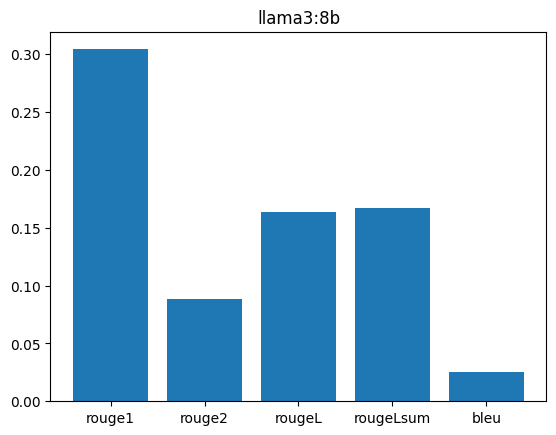

In [16]:
import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [results_R[r] for r in x[:4]] + [results_B['bleu']]
plt.bar(x,y)
plt.title("llama3:8b")
plt.show()